# **INFERENCES**

The different models developed, tried and submitted are implemented in this notebook.
A private GitHub repository of the project is available [here](https://github.com/celine98/genhack).
___
___

## **INITIALIZATION**

### *IMPORTS*

In [57]:
from IPython.display import display # to display dataframes

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns # to provide plots
import warnings

from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

import torch
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision.utils as vutils

To create the ```requirement.txt``` file we use the following line of code:

In [2]:
import session_info
session_info.show()

### *DATA LOADING*

In [68]:
train_df = pd.read_csv("train.csv", index_col=0, names=["VAL1", "VAL2", "VAL3", "VAL4"])

### *DATA ANALYSIS*

In [69]:
display(train_df)

,VAL1,VAL2,VAL3,VAL4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


In [70]:
# some statistics about the dataframe values
display(train_df.describe())

,VAL1,VAL2,VAL3,VAL4
count,746.000000,746.000000,746.000000,746.000000
mean,0.013144,0.012822,0.009366,0.010788
std,0.011914,0.011712,0.009283,0.009338
min,0.000012,0.000057,0.000014,0.000067
25%,0.004761,0.003878,0.003202,0.004226
50%,0.010030,0.009423,0.006641,0.008508
75%,0.017771,0.017810,0.012354,0.014221
max,0.098709,0.088502,0.072016,0.074291


In [71]:
# correlations between values considering the features (except "count") from the previous dafaframe
train_df.describe().iloc[[i for i in range(1,8)]].corr()

,VAL1,VAL2,VAL3,VAL4
VAL1,1.000000,0.999681,0.999855,0.999907
VAL2,0.999681,1.000000,0.999487,0.999744
VAL3,0.999855,0.999487,1.000000,0.999602
VAL4,0.999907,0.999744,0.999602,1.000000


To build our models we will only work with normalized (standardised data). However when predicting our generating values we will need to un-normalize the values obtained. 

In [81]:
train_df_normalized = (train_df - train_df.mean()) / train_df.std()

### *DATA VISUALIZATION*

#### **Non-normalized data**

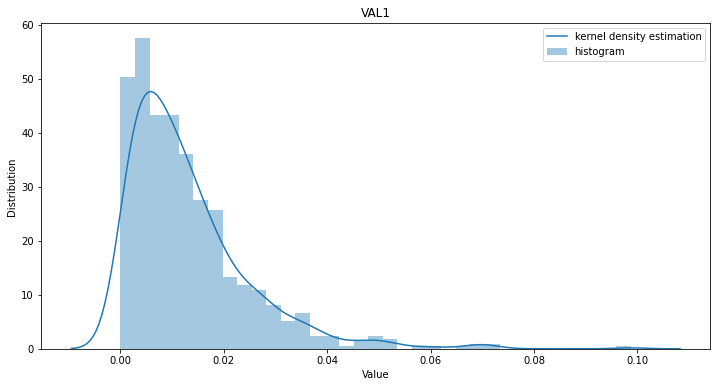

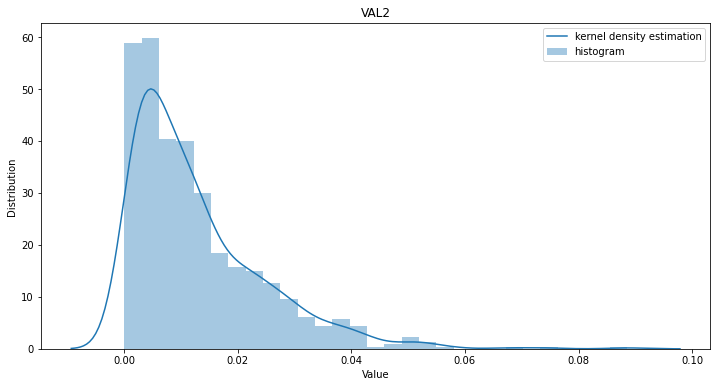

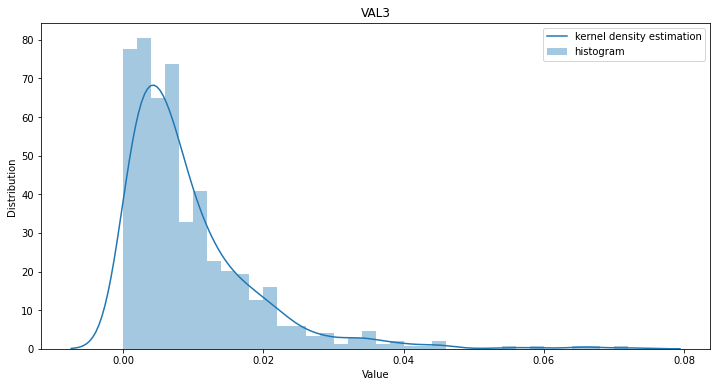

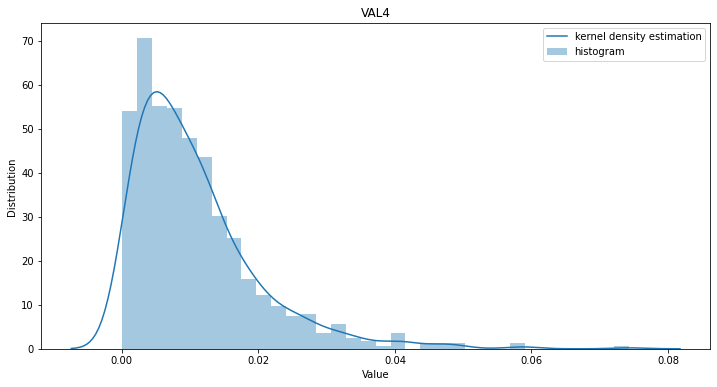

In [82]:
# plot the data distribution for each of the (not normalized) values/dimensions
warnings.simplefilter(action='ignore', category=FutureWarning)
for column in train_df.columns:
    plt.figure(figsize=(12,6))
    sns.distplot(train_df[column])
    plt.xlabel("Value")
    plt.ylabel("Distribution")
    plt.title(column)
    plt.legend(labels=["kernel density estimation", "histogram"])
    plt.show()

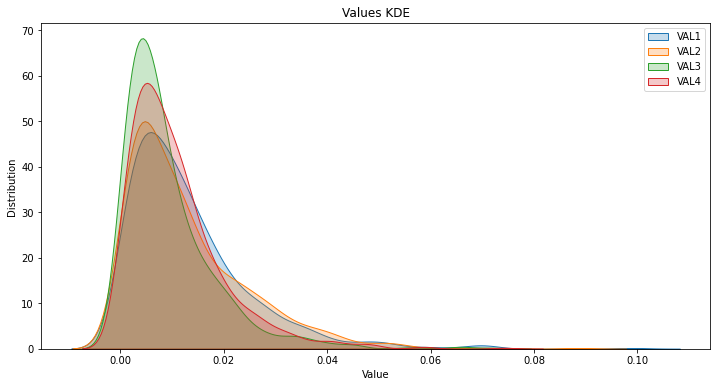

In [83]:
# plot the overlapping kernel distributions for all the (non-normalized) values
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12,6))
for column in train_df.columns:
    sns.kdeplot(train_df[column], shade=True)
plt.xlabel("Value")
plt.ylabel("Distribution")
plt.title("Values KDE")
plt.legend(labels=["VAL1", "VAL2", "VAL3", "VAL4"])
plt.show()

#### **Normalized data**

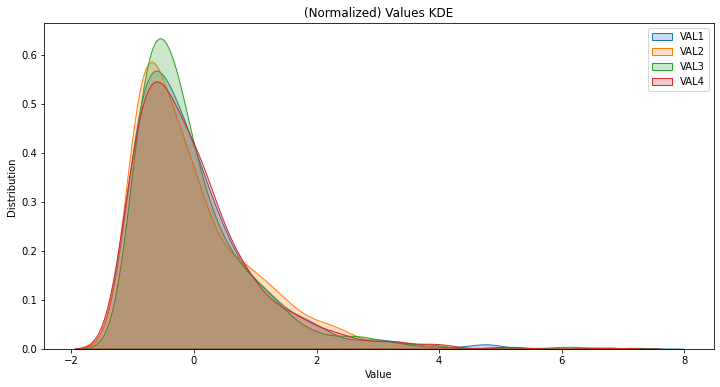

In [88]:
# plot the overlapping kernel distributions for all the (normalized) values
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.figure(figsize=(12,6))
for column in train_df_normalized.columns:
    sns.kdeplot(train_df_normalized[column], shade=True)
plt.xlabel("Value")
plt.ylabel("Distribution")
plt.title("(Normalized) Values KDE")
plt.legend(labels=["VAL1", "VAL2", "VAL3", "VAL4"])
plt.show()

___

### *METRICS*

In [118]:
p = np.array([[1,2,3],[4,5,6],[7,8,9]])
v = p[:,0]
v

array([1, 4, 7])

In [135]:
# Anderson-Darling distance
def AD(X1,X2):

    assert (X1.shape == X2.shape)
    
    n,d = X1.shape

    u = np.zeros((n,d))
    for t in range(d):
        X2_t = list(X2[:,t])
        X2_t.sort()
        for i in range(n):
            X1_t = list(X1[:,t])
            X1_t.sort()
            value = 1
            for j in range(n):
                if (X1_t[j]<X2_t[i]):
                    value += 1
            u[i][t] = value/(n+2)
    
    W = np.zeros(d)
    for t in range(d):
        W[t] = -n - (1/n) * np.sum([(2*i-1) * (np.log(u[i][t]) + np.log(1-u[n-i-1][t])) for i in range(n)])

    return (1/d) * np.sum(W)

In [130]:
# Absolute-Kendall-Error between two sets of the same size
def AKE(X1, X2):

    assert (X1.shape == X2.shape)

    Z1, Z2, n = [], [], X1.shape[0]

    for i in range(n):
        Z1_i, Z2_i = 0, 0
        for j in range(n):
            if i != j:
                if (np.min(X1[i]-X1[j]) > 0):
                    Z1_i += 1
                if (np.min(X2[i]-X2[j]) > 0):
                    Z2_i += 1
        Z1.append(Z1_i/(n-1))
        Z2.append(Z2_i/(n-1))
    
    Z1.sort()
    Z2.sort()

    return (1/n) * sum([abs(Z1[i]-Z2[i]) for i in range(n)])

In [131]:
X1 = np.array([
    [2, 0, 4, 2, 3, 1, 2, 5, 6, 7, 8],
    [1, 0, 3, 1, 2, 1, 2, 5, 6, 7, 8]])   
X2 = np.array([
    [2, 3, 3, 3, 2, 2, 3, 5, 2, 5, 8],
    [1, 2, 2, 2, 2, 2, 3, 4, 6, 7, 8]])
print(AD(X1,X2))
print(AKE(X1,X2))

(2, 11)
[1, 2] [1, 2]
[0, 0] [2, 3]
[3, 4] [2, 3]
[1, 2] [2, 3]
[2, 3] [2, 2]
[1, 1] [2, 2]
[2, 2] [3, 3]
[5, 5] [4, 5]
[6, 6] [2, 6]
[7, 7] [5, 7]
[8, 8] [8, 8]
None
0.0


___

## **DATA PREPROCESSING**

### *DATA VISUALIZATION*

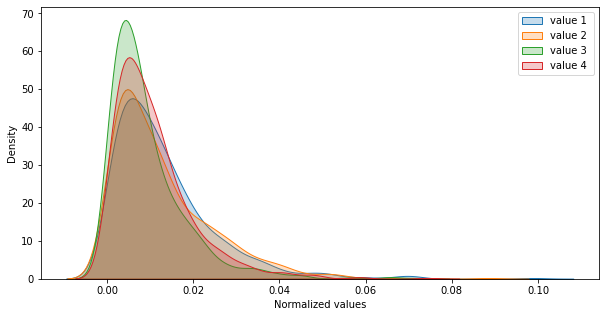

In [8]:
plt.figure(figsize=(10,5))
for column in train_df.columns:
    sns.kdeplot(train_df[column], shade=True)
plt.xlabel("Normalized values")
plt.legend(labels=["value 1", "value 2 ", "value 3", "value 4"])
plt.show()

___

## **Basic GAN**

Based on this [GitHub tutorial](https://github.com/tomsercu/gan-tutorial-pytorch/blob/master/2019-04-23%20GAN%20Tutorial.ipynb).

### *DEFINING THE NEURAL NETWORKS*

In [75]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("device: {}".format(device))

device: cuda


In [87]:
class Disciminator(nn.Module):

    def __init__(self, input_size=4):
        super(Disciminator, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(64, 16)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(16, 1)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        return torch.sigmoid(self.fc3(o))

In [88]:
class Generator(nn.Module):

    def __init__(self, z_size=50):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(z_size, 16)
        self.nl1 = nn.LeakyReLU(0.25)
        self.fc2 = nn.Linear(16, 64)
        self.nl2 = nn.LeakyReLU(0.125)
        self.fc3 = nn.Linear(64, 4)
    
    def forward(self, x):
        o = self.nl1(self.fc1(x))
        o = self.nl2(self.fc2(o))
        return self.fc3(o)
        

In [89]:
D = Disciminator().to(device)
print(D)

G = Generator().to(device)
print(G)

Disciminator(
  (fc1): Linear(in_features=4, out_features=64, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=64, out_features=16, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)
Generator(
  (fc1): Linear(in_features=50, out_features=16, bias=True)
  (nl1): LeakyReLU(negative_slope=0.25)
  (fc2): Linear(in_features=16, out_features=64, bias=True)
  (nl2): LeakyReLU(negative_slope=0.125)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


### *TESTING THE NEURAL NETWORKS*

In [90]:
samples = torch.randn(5, 4).to(device)
D(samples)

tensor([[0.5489],
        [0.5105],
        [0.5542],
        [0.5159],
        [0.4976]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [91]:
z_samples = torch.randn(5, 50).to(device)
G(z_samples)

tensor([[-0.1515, -0.2312,  0.0429, -0.0864],
        [-0.1991,  0.0209,  0.0557,  0.1031],
        [-0.2481, -0.2590, -0.0076, -0.0267],
        [-0.3378, -0.3958,  0.0304, -0.1255],
        [-0.2812, -0.1616,  0.0613, -0.0307]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

### *DATASET LOADING*

In [92]:
batch_size = 64

features = torch.tensor(train_df_normalized.values).to(device)
true_targets = torch.ones((features.shape[0],1)).to(device)
fake_targets = torch.zeros((features.shape[0],1)).to(device)

train_ds = data_utils.TensorDataset(features, true_targets)
train_ds_loader = data_utils.DataLoader(train_ds, batch_size=batch_size, shuffle=True)

### *TRAINING THE NETWORKS*

In [93]:
optimizerD = optim.SGD(D.parameters(), lr=0.05)
optimizerG = optim.SGD(G.parameters(), lr=0.05)

In [94]:
criterion = nn.BCELoss()
n_epochs = 10000
fixed_noise = torch.randn(batch_size, 50).to(device)
collect_x_gen = []

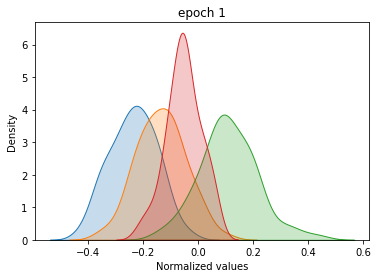

e0 / last mb D(x)=12.0000 D(G(z))=0.5216


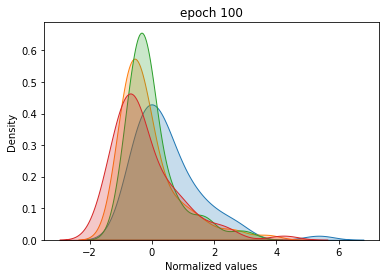

e99 / last mb D(x)=12.0000 D(G(z))=0.5143


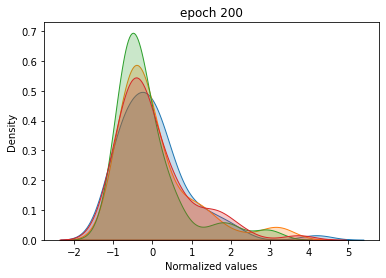

e199 / last mb D(x)=12.0000 D(G(z))=0.5079


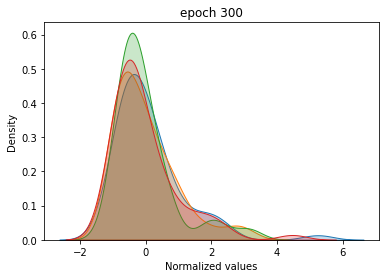

e299 / last mb D(x)=12.0000 D(G(z))=0.5077


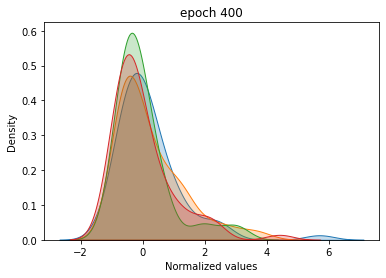

e399 / last mb D(x)=12.0000 D(G(z))=0.5077


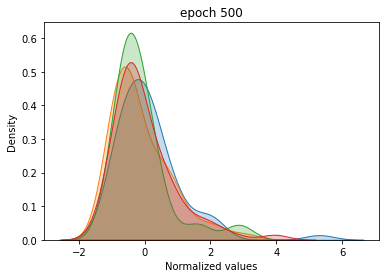

e499 / last mb D(x)=12.0000 D(G(z))=0.5300


KeyboardInterrupt: 

In [95]:
for epoch in range(n_epochs):

    for i,data in enumerate(train_ds_loader, 0):

        # STEP 1 : Discriminator optimization step

        optimizerD.zero_grad()

        x_real, y_real = iter(train_ds_loader).next()
        x_real = x_real.float()
        D_x_real = D(x_real)
        lossD_real = criterion(D_x_real, torch.ones((x_real.shape[0],1)).to(device))

        z = torch.randn(batch_size, 50).to(device)
        x_gen = G(z).detach()
        D_x_gen = D(x_gen)
        lossD_fake = criterion(D_x_gen, torch.zeros((x_gen.shape[0],1)).to(device))

        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()

        # STEP 2 : Generator optimization step

        optimizerG.zero_grad()

        z = torch.randn(batch_size, 50).to(device)
        x_gen = G(z)
        
        D_x_gen = D(x_gen)
        lossG = criterion(D_x_gen, torch.ones((x_gen.shape[0],1)).to(device))

        lossG.backward()
        optimizerG.step()

    if (epoch+1)%100 == 0 or epoch==0:
        x_gen = G(fixed_noise)
        x_gen_df = pd.DataFrame(x_gen.cpu().detach().numpy())
        for column in x_gen_df.columns:
            sns.kdeplot(x_gen_df[column], shade=True)
        plt.title("epoch {}".format(epoch+1))
        plt.xlabel("Normalized values")
        plt.show()
        print("e{} / last mb D(x)={:.4f} D(G(z))={:.4f}".format(
            epoch, len(train_ds_loader), D_x_real.mean().item(), D_x_gen.mean().item()
        ))
    
    x_gen = G(fixed_noise)
    collect_x_gen.append(x_gen.detach().clone())

In [ ]:
x=0